# FBAgd paper Results section

## Notebook setup and supporting code

In [1]:
import ipywidgets as widgets
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
from IPython.display import SVG, display

from mosmo.calc import fba_gd, elementary_modes, convenience_kinetics
from mosmo.knowledge import kb
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, Pathway
from mosmo.preso.escher import escher_map
from mosmo.knowledge.thermo import Thermodynamics

%matplotlib widget
plt.ioff()
rando = np.random.default_rng()
jax.config.update('jax_enable_x64', True)

KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=273.15 + 37)
RT = thermo.cc.RT.magnitude

class BiomassObjective(fba_gd.Objective):
    def __init__(self, pw, biomass_components, growth_rate, weight=1.0):
        super().__init__(weight)
        self.pw = pw
        self.indices = np.array([pw.molecules.index_of(component) for component in biomass_components.keys()], dtype=np.int32)
        self.fractions = pw.molecules.pack(biomass_components)[self.indices]
        self.growth_rate = growth_rate
    
    def params(self):
        return self.fractions, self.growth_rate
    
    def update_params(self, biomass_components=None, growth_rate=None):
        if biomass_components is not None:
            self.fractions = self.pw.molecules.pack(biomass_components)
        if growth_rate is not None:
            self.growth_rate = growth_rate

    def residual(self, velocities, dmdtv, params):
        fractions, growth_rate = params
        expected = growth_rate * fractions
        actual = dmdtv[self.indices]
        return actual - expected

def report(growth_rate, fluxv, dmdtv):
    # uses pw, boundaries, intermediates, recyclers

    fluxes = pw.reactions.unpack(fluxv)
    dmdt = pw.molecules.unpack(dmdtv)
    
    fig, ax = plt.subplots(2, 1, figsize=(3, 4), height_ratios=[2, 1], layout='constrained', sharex=True)
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.toolbar_visible = False
    fig.canvas.resizable = False

    reported_boundaries = boundaries[:-2]  # skips H+ and e-
    y = np.arange(len(reported_boundaries))
    ax[0].set_title('Boundary Fluxes')
    ax[0].set_yticks(y, labels=[b.label for b in reported_boundaries])
    ax[0].invert_yaxis()
    ax[0].grid(True)
    ax[0].axvline(0)
    ax[0].barh(y, [dmdt[mol] for mol in reported_boundaries])

    y = np.arange(len(recyclers))
    ax[1].set_title('Net Production')
    ax[1].set_xlabel('Rate')
    ax[1].set_yticks(y, labels=['ATP', 'NADH', 'NADPH'])
    ax[1].invert_yaxis()
    ax[1].grid(True)
    ax[1].axvline(0)
    ax[1].barh(y, [fluxes[r] for r in recyclers])

    diag = escher_map.EscherMap(pw.diagram, width='15cm', reaction_scale=escher_map.Scale({0: ('#eeeeee', 10), 20: ('#1f77b4', 40)}, use_abs=True))
    diag_canvas = widgets.Output()
    with diag_canvas:
        svg = diag.draw(reaction_data={rxn.id: flux for rxn, flux in fluxes.items()})
        display(SVG(svg))


    # Lay it all and return
    i_intermediate = np.array(list(pw.molecules.index_of(mol) for mol in intermediates))
    return widgets.HBox([
        widgets.VBox([
            widgets.Label(f'Growth rate: {growth_rate:.2e}'),
            # widgets.Label(f'Steady state RMS error: {np.sqrt(np.mean(np.square(dmdtv[i_intermediate]))):.2e}'),
            fig.canvas,
        ], layout=widgets.Layout(width='4in', padding='10px')),
        diag_canvas,
    ], layout = widgets.Layout(width='1000px', border='1px solid green'))

## Pathway Definition: Glycolysis, Pentose Phosphate, Acetate Overflow

pw consists of 24 reactions on 33 metabolites (19 intermediates + 8 boundaries)


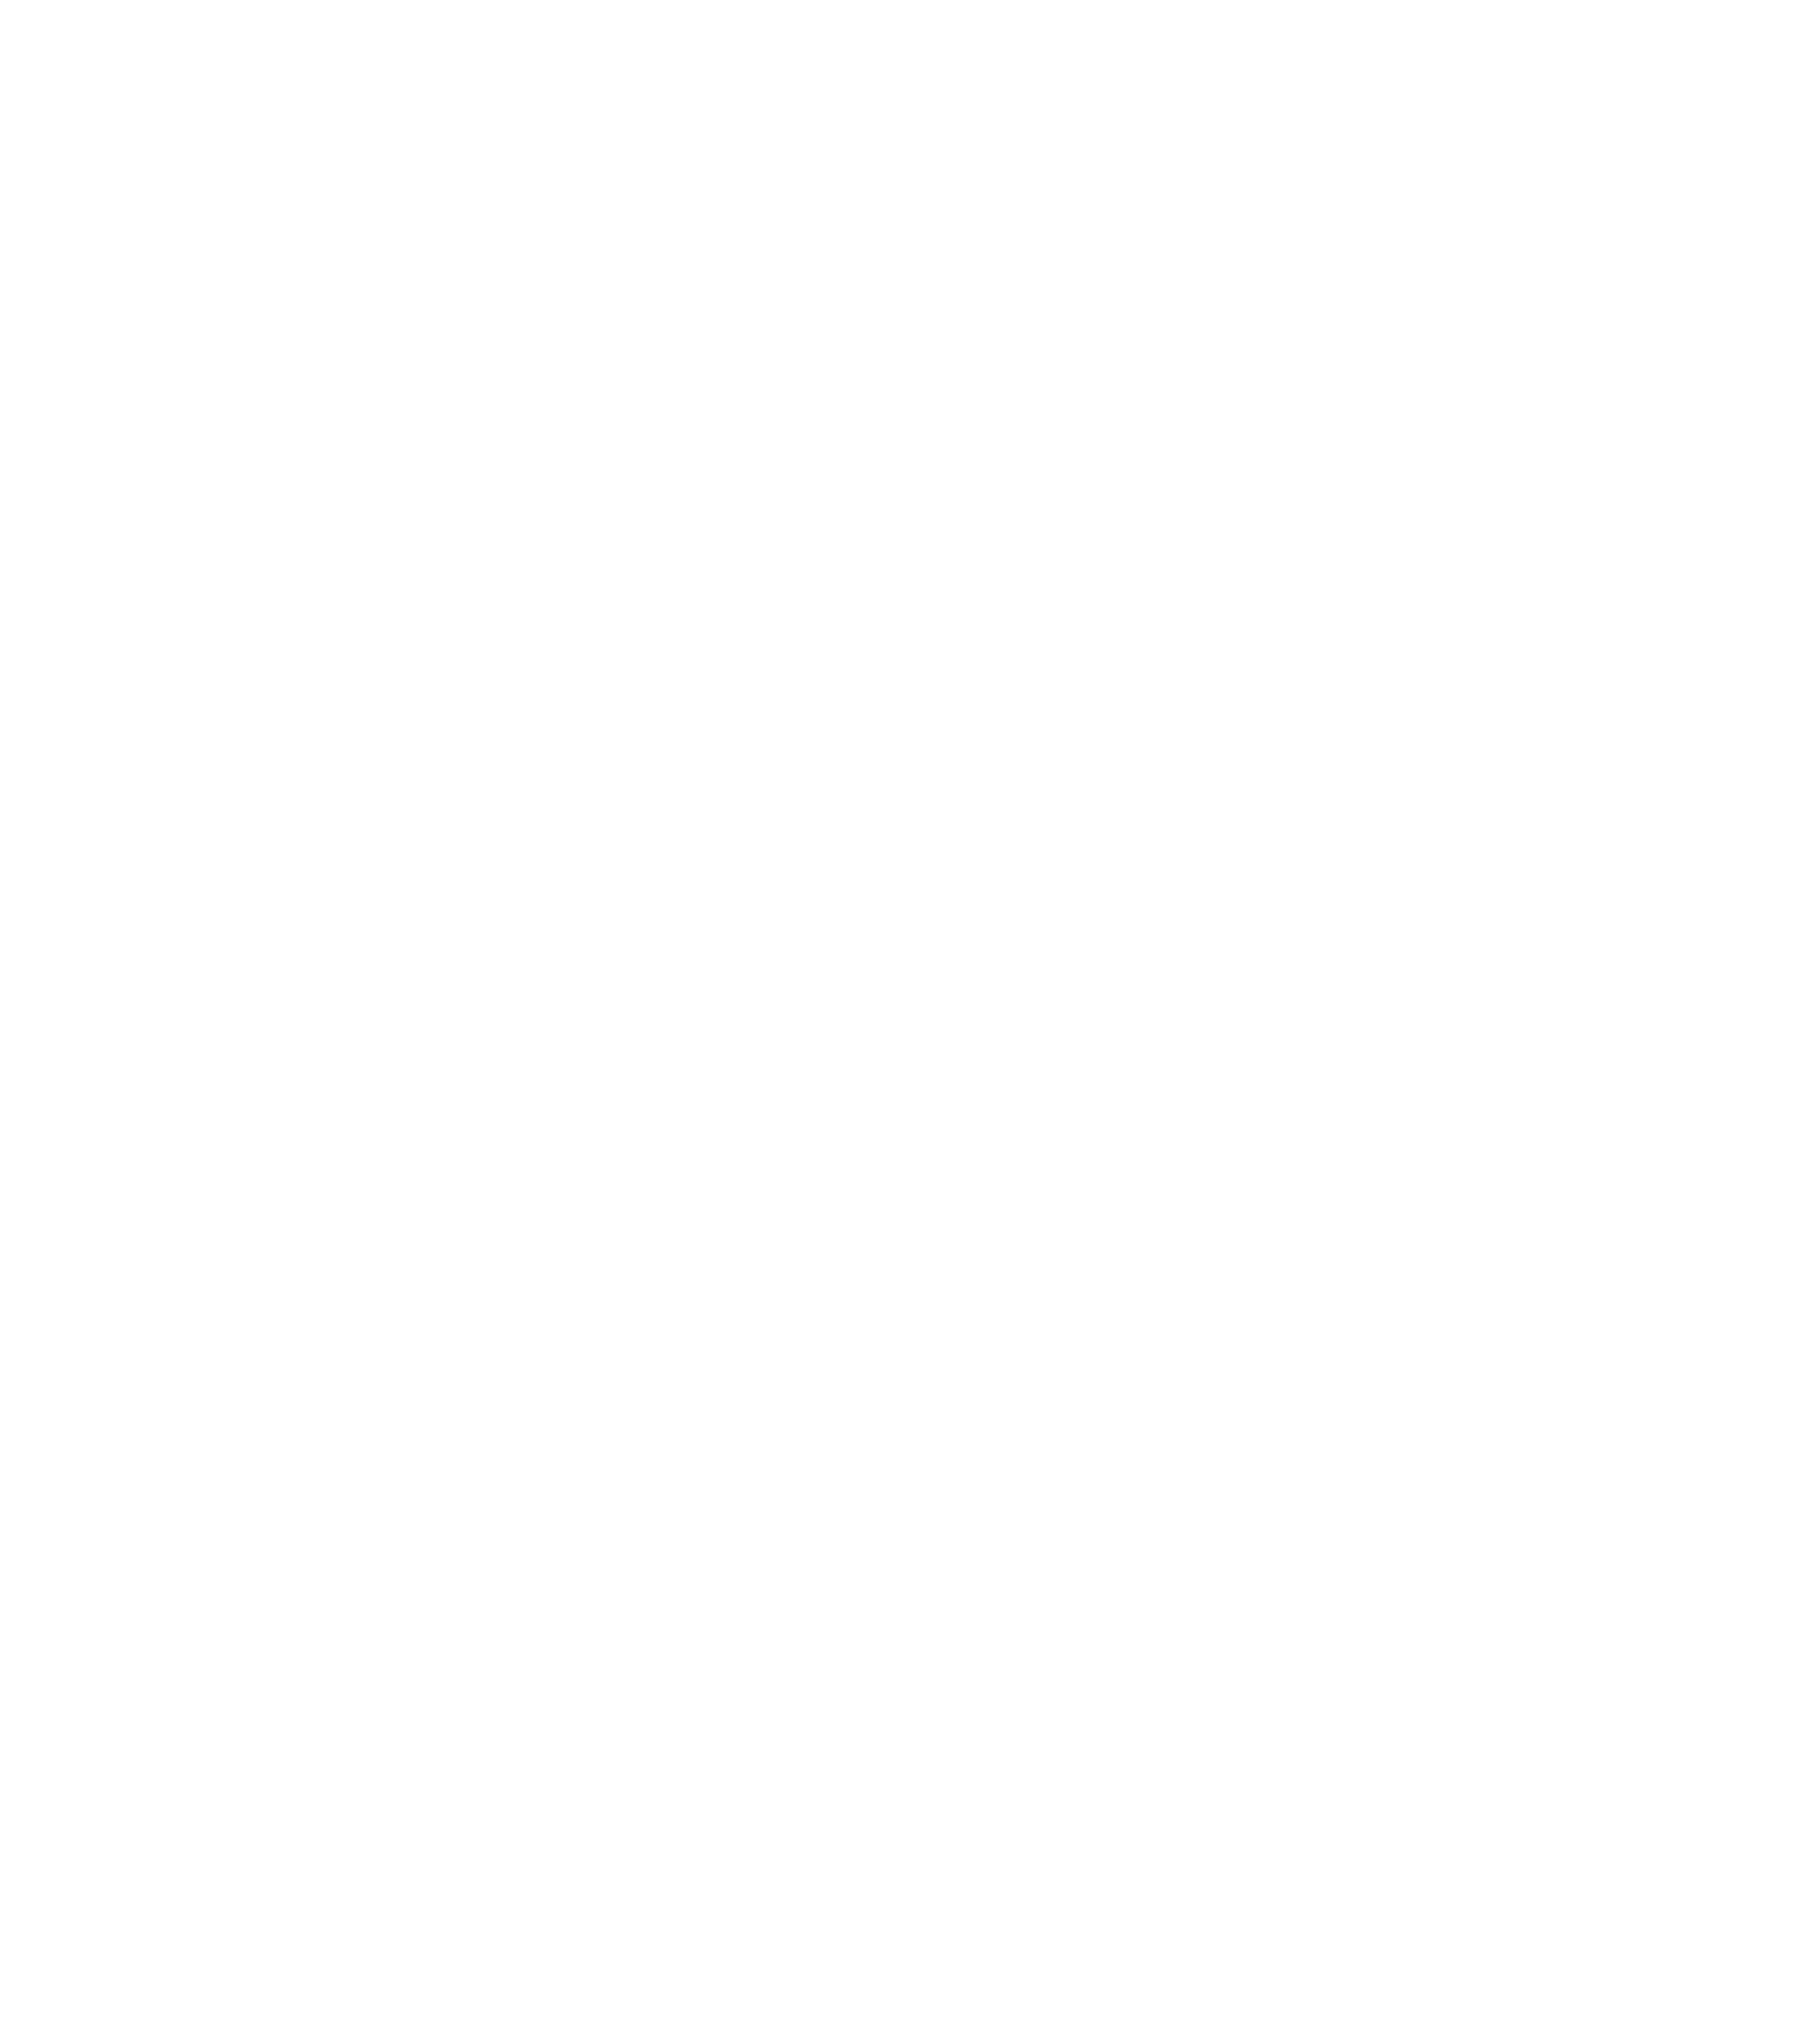

In [2]:
pw = KB('glycolysis_ppp_ov_simplified')

# Boundary/recycling reactions: ATPase NADox, NADPox
recyclers = [KB(rxnid) for rxnid in ['atpase', 'nad_ox', 'nadp_ox']]
for rxn in recyclers:
    pw.add_reaction(rxn)

# Glc[e] is available for (limited) uptake, along with water, Pi, CoA, H+, and e-, which are assumed to be balanced by other processes in the cell. Other boundaries are efflux-only.
boundaries=[KB(mol_id) for mol_id in ['Glc.D.ext', 'h2o', 'pi', 'coa', 'co2', 'ac', 'h+', 'e-']]
limits = {
    KB('Glc.D.ext'): (-10, 0),
    KB('co2'): (0, None),
    KB('ac'): (0, None),
}
biomass_components = {
    KB('Glc.D.6P'): 0.212,
    KB('Ery.D.4P'): 0.361,
    KB('Rib.D.5P'): 0.898,
    KB('gap'): 0.13,
    KB('pep'): 4.89,
    KB('accoa'): 10.75,
}

# Anything not on a boundary is an intermediate, and assumed to be at steady-state. Given the recycling reactions, the cofactors can be treated as intermediates.
intermediates = [mol for mol in pw.molecules if mol not in boundaries and mol not in biomass_components]

print(f'pw consists of {len(pw.reactions)} reactions on {len(pw.molecules)} metabolites ({len(intermediates)} intermediates + {len(boundaries)} boundaries)')
diag = escher_map.EscherMap(pw.diagram, width='15cm', metabolite_scale=escher_map.Scale({0: ('#bbbbbb', 15), 1: ('#e0865b', 20)}))
SVG(diag.draw(metabolite_data={m.id: 1 if m in boundaries else 0 for m in pw.molecules}))

## FBA via Linear Programming with Maximal Growth Objective

In [3]:
# Following the form of scipy.optimize.linprog:
# minimize c @ x: c is coefficients of the flux vector to optimize, i.e. [-1, 0, ...]
c = np.insert(np.zeros(pw.shape[1]), 0, -1.0)
# Augment S and v with additional column + variable for growth
s_aug = np.hstack([-pw.molecules.pack(biomass_components)[:, np.newaxis], pw.s_matrix])

# s.t. A_eq @ x = b_eq: A_eq is the subset of s_aug for rows that are steady-state; b_eq = 0
i_intermediates = np.array([i for i, mol in enumerate(pw.molecules) if mol in intermediates or mol in biomass_components])
A_eq = s_aug[i_intermediates]
b_eq = np.zeros(A_eq.shape[0])

#  s.t. A_ub @ x <= b_ub: A_ub is a transformed subset of s_aug that constrains non steady-state (boundary) dm/dt; b_ub sets the bounds
i_limits = np.array([pw.molecules.index_of(mol) for mol in limits.keys()])
A_ub = -s_aug[i_limits]
b_ub = np.array([-l[0] for l in limits.values()])

# s.t. lb <= x <= ub: constraints on the fluxes themselves, mainly reversibility (including growth)
bounds = [(0, None)] + [(None, None) if rxn.reversible else (0, None) for rxn in pw.reactions]

lp_soln = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
growth_rate = lp_soln.x[0]
report(growth_rate, lp_soln.x[1:], pw.s_matrix @ lp_soln.x[1:])

## Recast using FBA-GD and gradient-friendly objectives

In [4]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates),
    'irreversibility': fba_gd.IrreversibilityObjective(pw),
    'biomass': BiomassObjective(pw, biomass_components, growth_rate),
    'limits': fba_gd.ProductionObjective(pw, limits),
}

# Generalized residual combining the objectives
def residual(v, *params):
    dmdtv = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdtv, p) for objective, p in zip(objectives.values(), params)])

# Cache the jitted loss and jacobian functions
_residual_jit = jax.jit(residual)
_residual_jac = jax.jit(jax.jacfwd(residual))

# Solve least squares on combined residual
v0 = rando.random(pw.shape[1])

params = tuple(objective.params() for objective in objectives.values())
soln = scipy.optimize.least_squares(fun=_residual_jit, args=params, x0=v0, jac=_residual_jac)
dmdtv = pw.s_matrix @ soln.x
fit_residual = np.concatenate([objectives[name].residual(soln.x, dmdtv, None) for name in ['steady-state', 'irreversibility']])
fba_soln_1 = fba_gd.FbaResult(v0=v0, velocities=soln.x, dmdt=dmdtv, fit=float(np.sum(np.square(fit_residual))))

print(f'Fluxes agree with LP solution to within {np.sqrt(np.mean(np.square(lp_soln.x[1:] - fba_soln_1.velocities))):.1e} RMS')
report(growth_rate, fba_soln_1.velocities, fba_soln_1.dmdt)

Fluxes agree with LP solution to within 2.4e-15 RMS


## Using Thermodynamics to Infer Reaction Direction

In [5]:
# Concentrations in mM (then converted to M), taken (mostly) from Rabinowitz (2016)
concs = {KB(met_id): conc/1000 for met_id, conc in [
    ('2pg', 9.18e-02),
    ('3pg', 1.54),
    ('6pg', 3.77),
    ('6pgdl', 1.), # Not provided; reasonable guess
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.ext', 10.),  # Arbitrary; environment
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('ac', 1e-3),
    ('ac.P', 1.07E-03),
    ('accoa', 6.06e-01),
    ('adp', 5.55e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dhap', 3.06),
    ('dpg', 1.65e-02),
    ('gap', 2.71e-01),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),

    # Not used in calculation of ΔG or ΔG° in eQuilibrator. Set all to activity = 1.0 to drop out of any calculations.
    ('h+', 1000),
    ('h2o', 1000),
    ('e-', 1000),
]}

dgr0 = pw.reactions.pack({rxn: thermo.reaction_delta_g(rxn) for rxn in pw.reactions})
dgr_ref = pw.reactions.pack({rxn: thermo.reaction_delta_g(rxn, concs) for rxn in pw.reactions})

In [6]:
ln_conc_ref = np.log(pw.molecules.pack(concs))
ignore = {KB('h+'), KB('h2o'), KB('e-')}  # Not included in reaction quotient -- baked into reference ΔG
qmask = jnp.array([0 if molecule in ignore else 1 for molecule in pw.molecules])
qmatrix = pw.s_matrix.T * qmask

def thermo_violation(fluxv, ln_conc):
    dgr = dgr0 + RT * (qmatrix @ ln_conc)
    # Reaction flux and ΔG must have opposite signs.
    return jnp.maximum(0, fluxv * dgr)


objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates, weight=1e6),
    'biomass': BiomassObjective(pw, biomass_components, growth_rate),
    'limits': fba_gd.ProductionObjective(pw, limits),
}

# Vector x = <fluxv><ln_concv>
def fun(x):
    v = x[:pw.shape[1]]
    ln_conc = x[-pw.shape[0]:]
    dmdtv = pw.s_matrix @ v
    residuals = []
    
    # FBA objective residuals
    for objective in objectives.values():
        residuals.append(objective.residual(v, dmdtv, objective.params()))
    
    # Deviation from measured concentrations
    residuals.append((ln_conc - ln_conc_ref))
    
    # Violation of theromodynamic direction
    residuals.append(thermo_violation(v, ln_conc))
    
    return jnp.concatenate(residuals)


x0 = rando.random(pw.shape[1] + pw.shape[0])
soln = scipy.optimize.least_squares(fun=jax.jit(fun), x0=x0, jac=jax.jit(jax.jacfwd(fun)))
fluxv = soln.x[:pw.shape[1]]
dmdtv = pw.s_matrix @ fluxv
ln_concv = soln.x[pw.shape[1]:]

fit_residual = np.concatenate([objectives['steady-state'].residual(fluxv, dmdtv, None), thermo_violation(fluxv, ln_concv)])
fba_soln_2 = fba_gd.FbaResult(v0=x0, velocities=fluxv, dmdt=dmdtv, fit=float(np.sum(np.square(fit_residual))))
report(growth_rate, fba_soln_2.velocities, fba_soln_2.dmdt)

### Highlight changes in concentration and/or flux

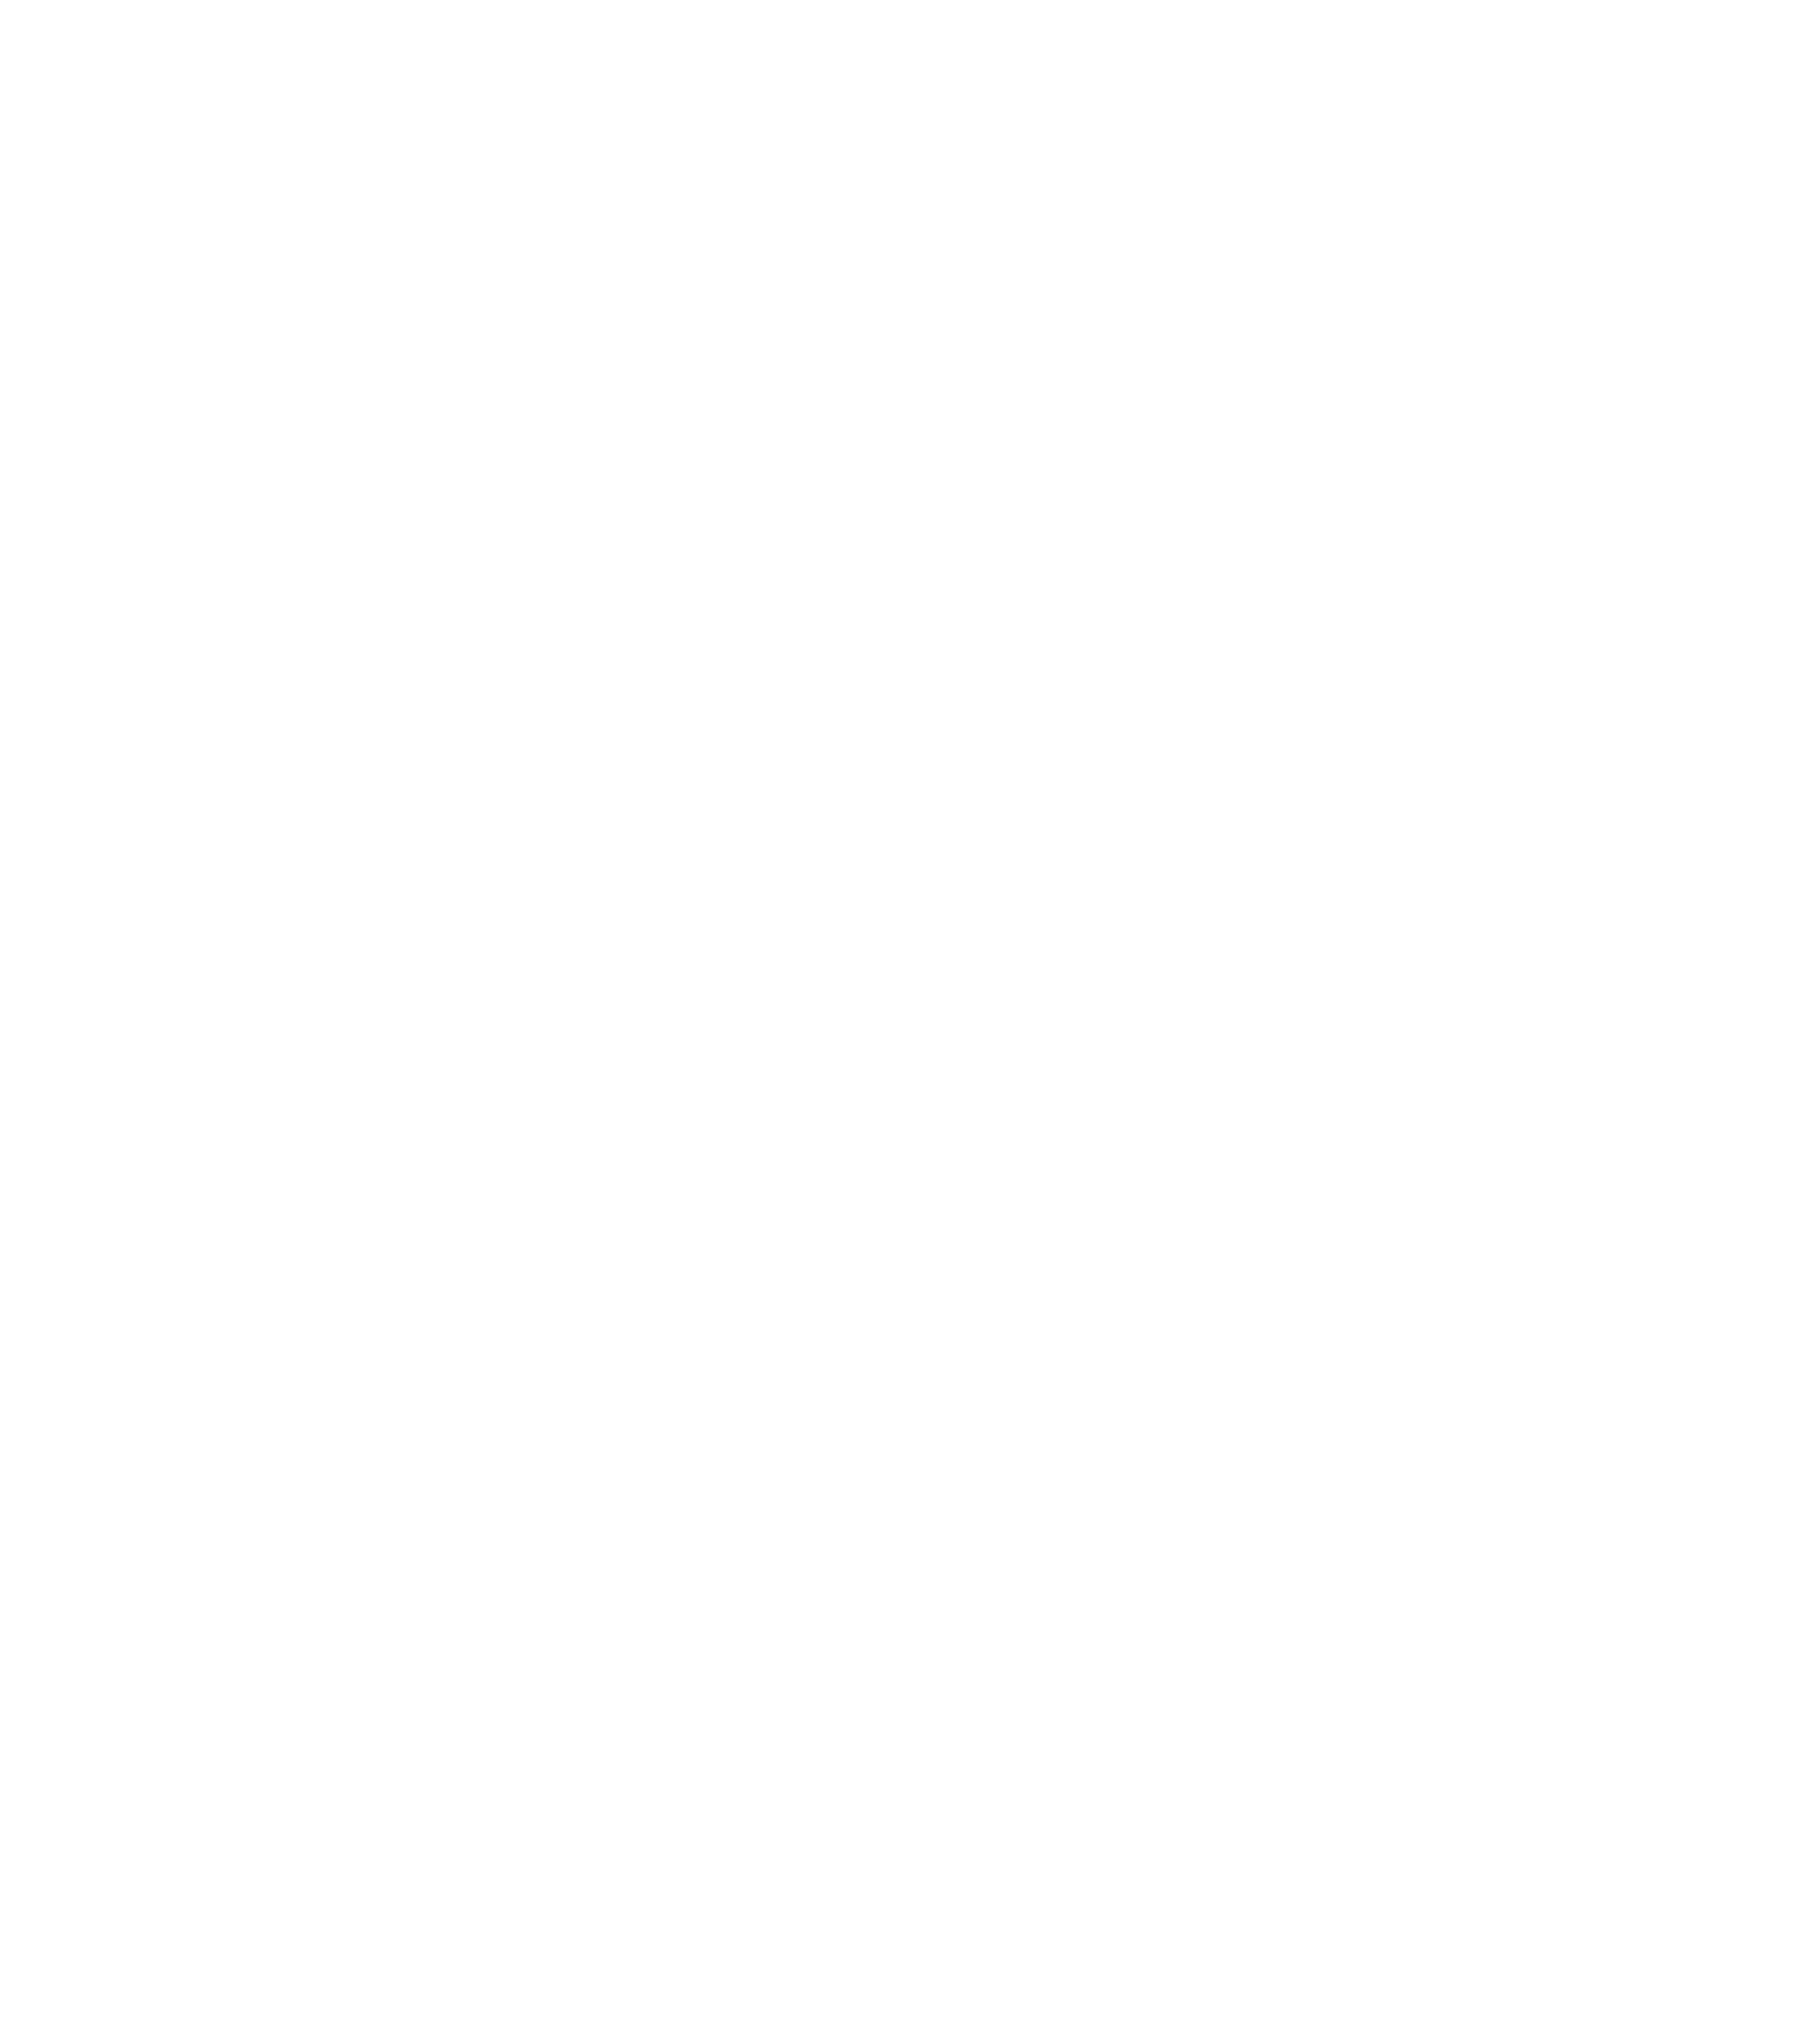

In [7]:
diag = escher_map.EscherMap(pw.diagram, 
                            width='15cm', 
                            metabolite_scale=escher_map.Scale({
                                -1: ('#ff3333', 20),
                                0: ('#eeeeee', 15), 
                                1: ('#3333ff', 20)
                            }),
                            reaction_scale=escher_map.Scale({
                                -5: ('#ff3333', 20),
                                -1: ('#aa3333', 15),
                                0: ('#000000', 10),
                                1: ('#eeeeee', 15), 
                                5: ('#3333ff', 20)
                            })
                           )
rdata = {}
for r, flux, ref_flux in zip(pw.reactions, fba_soln_2.velocities, lp_soln.x[1:]):
    # Intent is to avoid divide by zero, but don't highlight 0 => insignificant
    if ref_flux == 0:
        magnitude = min(abs(flux), 0.01)
        ref_flux = magnitude * np.sign(flux)
    rdata[r.id] = (flux / ref_flux)

SVG(diag.draw(
    metabolite_data={m.id: (conc - ref_conc) for m, conc, ref_conc in zip(pw.molecules, ln_concv, ln_conc_ref)},
    reaction_data=rdata, 
    reaction_direction={r.id: flux for r, flux in zip(pw.reactions, fluxv)},
))

## Overflow Metabolism

In [8]:
def optimize_from(v0s):
    objectives = {
        'steady-state': fba_gd.SteadyStateObjective(pw, intermediates),
        'irreversibility': fba_gd.IrreversibilityObjective(pw),
        'biomass': BiomassObjective(pw, biomass_components, growth_rate),
        'limits': fba_gd.ProductionObjective(pw, limits),
    }
    objectives['limits'].update_params({KB('Glc.D.ext'): -11})

    def residual(v):
        dmdtv = pw.s_matrix @ v
        return jnp.concatenate([objective.residual(v, dmdtv, objective.params()) for objective in objectives.values()])

    fluxes = []
    for v0 in v0s:
        soln = scipy.optimize.least_squares(fun=jax.jit(residual), x0=v0, jac=jax.jit(jax.jacfwd(residual)))
        fluxes.append(soln.x)
    return fluxes


def scatter_ov(fluxes, ax, markersize=None, alpha=1.0):
    fluxes = np.asarray(fluxes)
    dmdts = fluxes @ pw.s_matrix.T
    x = dmdts[:, pw.molecules.index_of(KB('ac'))]
    ax.scatter(x=x, y=fluxes[:, pw.reactions.index_of(KB('nad_ox'))], label='NADH', s=markersize, alpha=alpha)
    ax.scatter(x=x, y=fluxes[:, pw.reactions.index_of(KB('nadp_ox'))], label='NADPH', s=markersize, alpha=alpha)
    ax.scatter(x=x, y=fluxes[:, pw.reactions.index_of(KB('atpase'))], label='ATP', s=markersize, alpha=alpha)
    ax.scatter(x=x, y=dmdts[:, pw.molecules.index_of(KB('co2'))], label='CO2', s=markersize, alpha=alpha)
    return ax

### Random starting points around 0
- Tends to one extreme or the other, but we do get some coverage in the middle

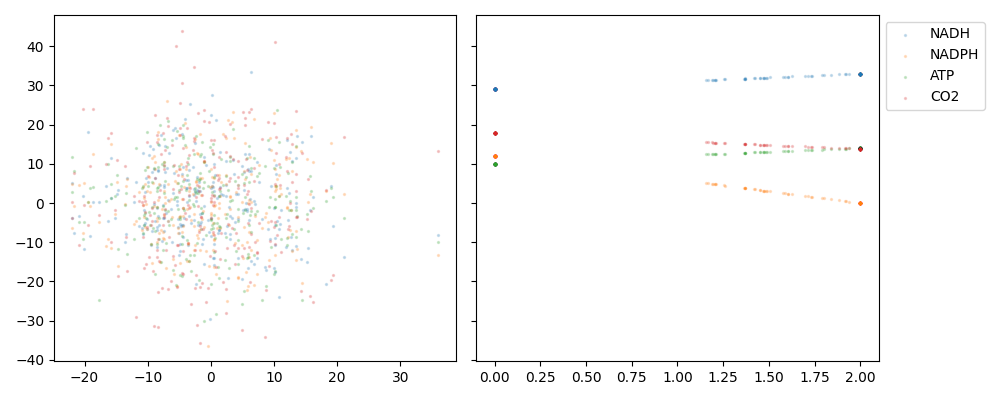

CPU times: user 20.1 s, sys: 53.7 ms, total: 20.1 s
Wall time: 20.1 s


In [9]:
%%time
vvv0 = rando.normal(scale=10.0, size=(250, pw.shape[1]))
vvv = np.array(optimize_from(vvv0))
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
scatter_ov(vvv0, ax[0], markersize=2, alpha=0.2)
scatter_ov(vvv, ax[1], markersize=2, alpha=0.2)
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.tight_layout()
plt.show()

### Systematically vary acetate production, over feasible range

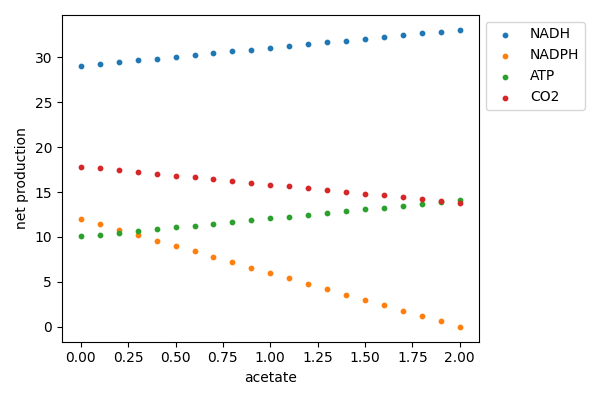

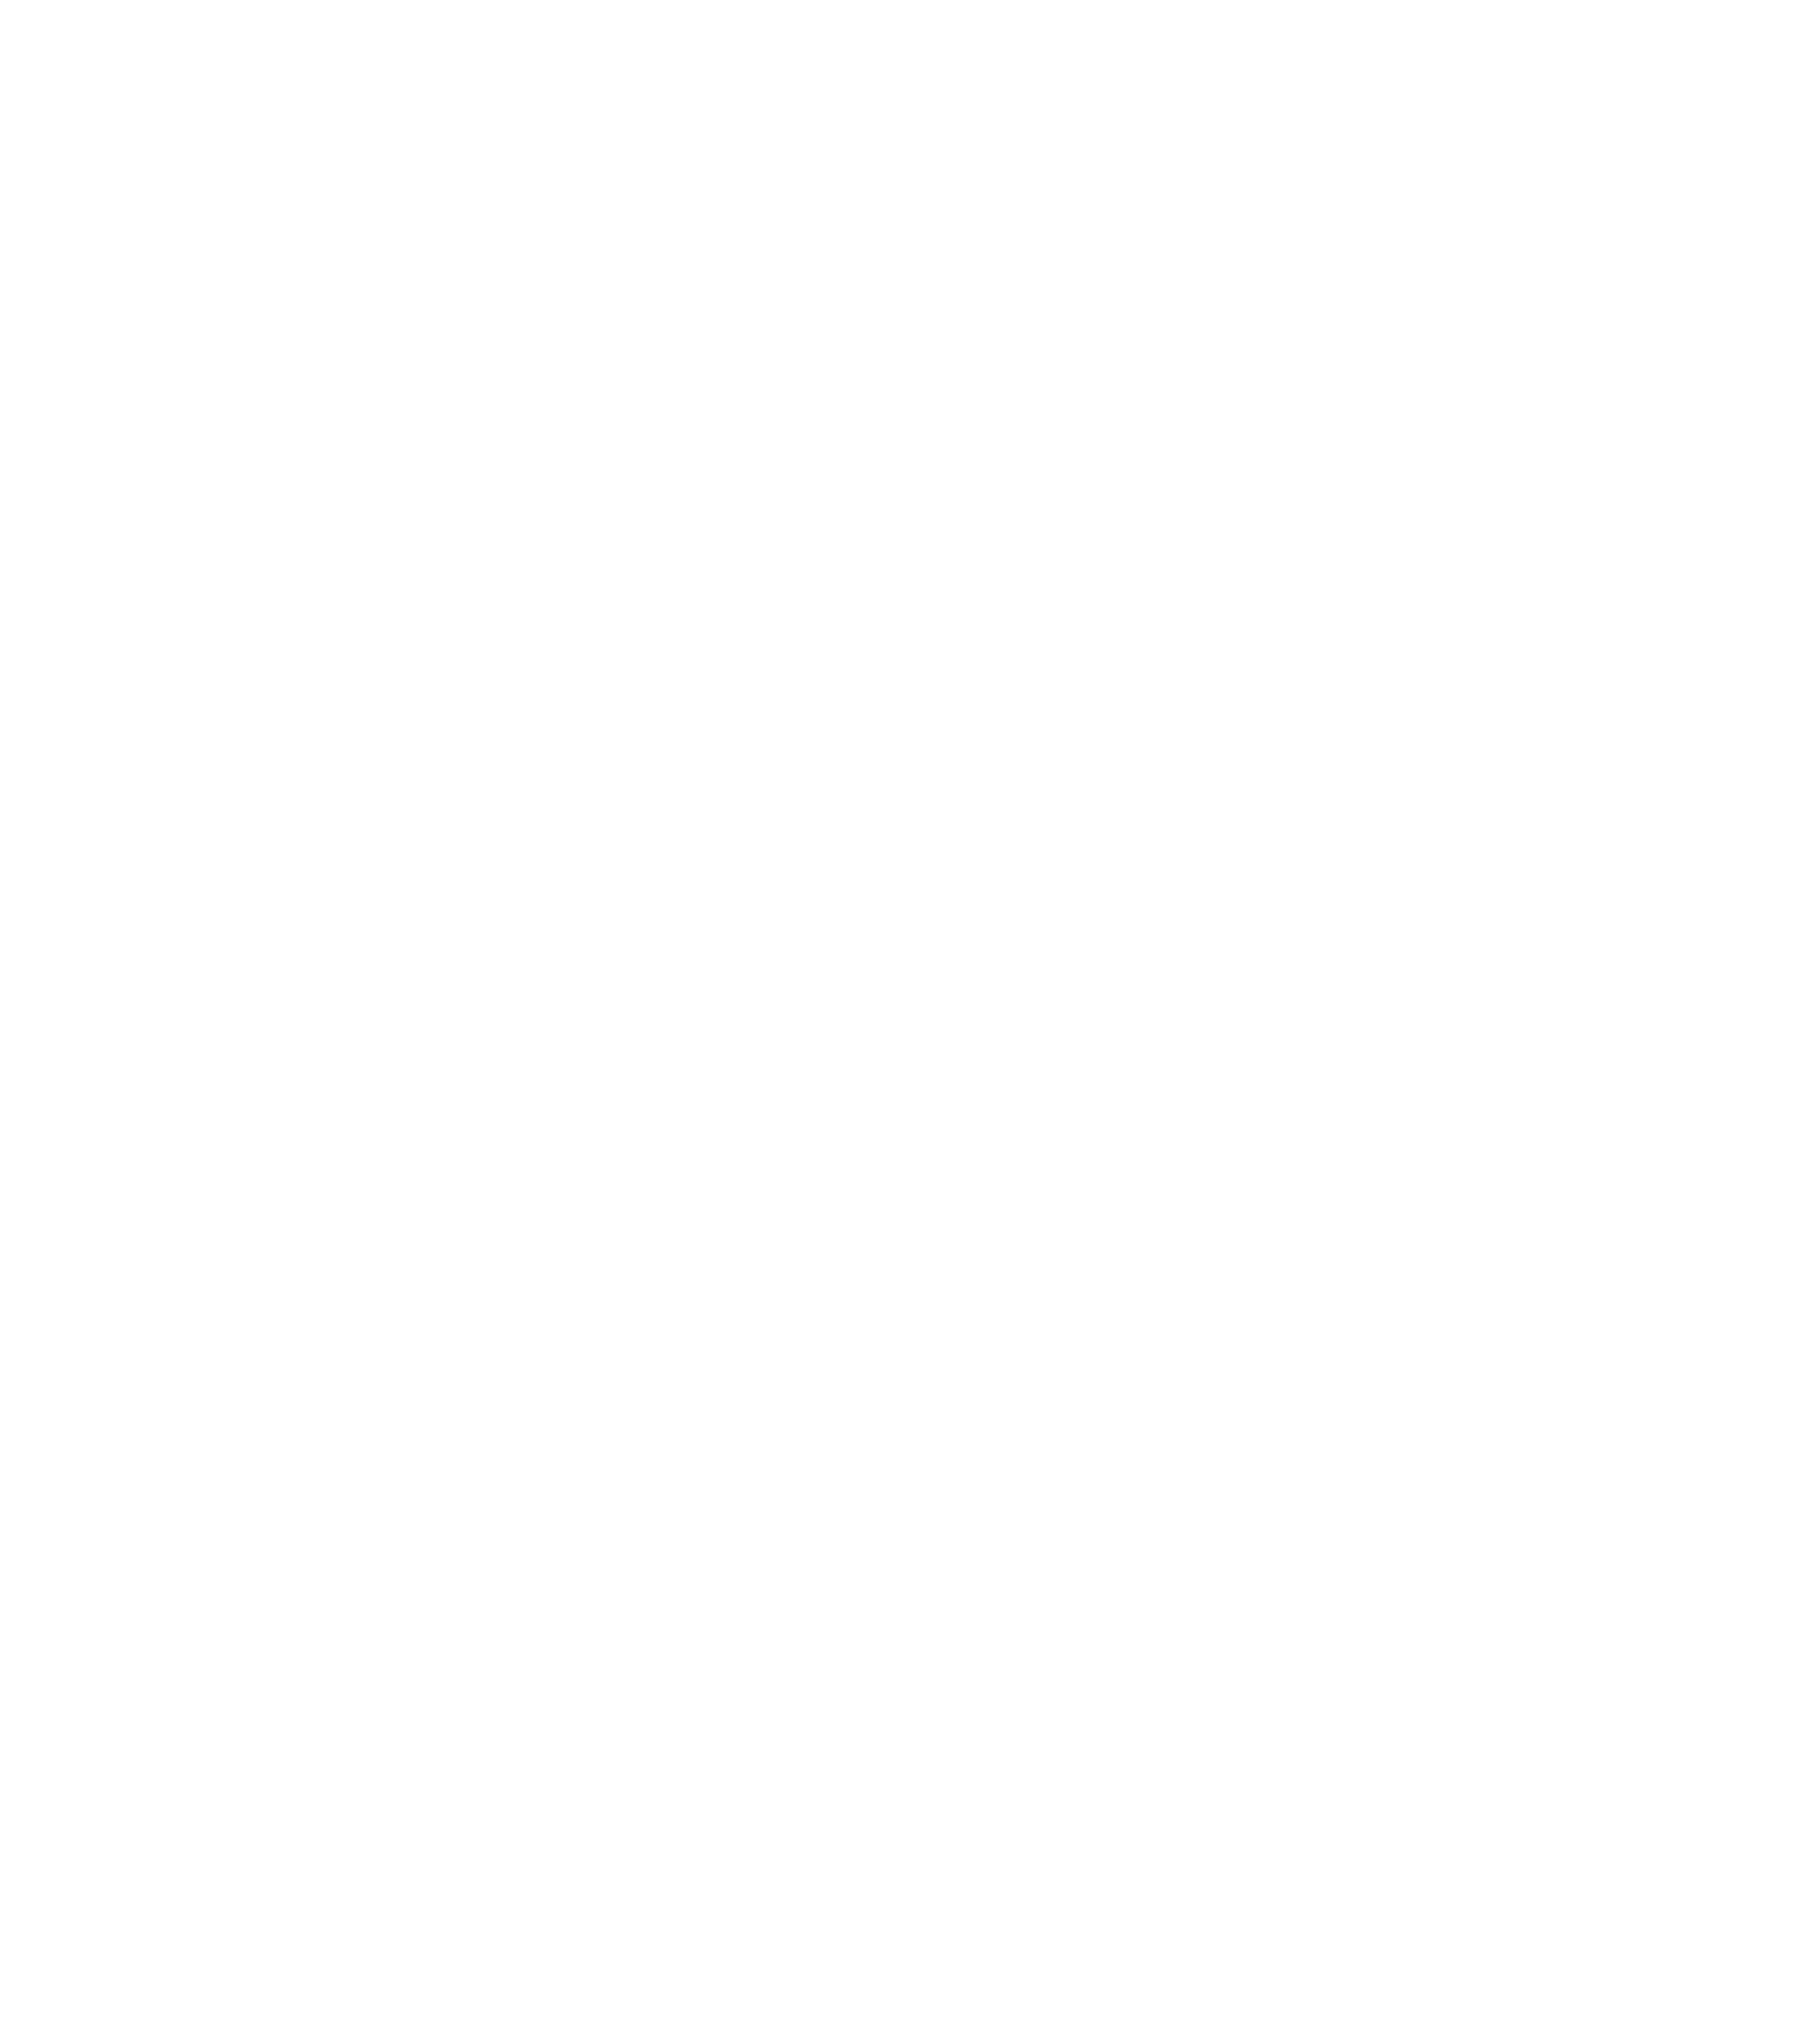

In [10]:
objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates),
    'irreversibility': fba_gd.IrreversibilityObjective(pw),
    'biomass': BiomassObjective(pw, biomass_components, growth_rate),
    'limits': fba_gd.ProductionObjective(pw, limits),
}
objectives['limits'].update_params({KB('Glc.D.ext'): -11})

def residual(v, *params):
    dmdtv = pw.s_matrix @ v
    return jnp.concatenate([objective.residual(v, dmdtv, p) for objective, p in zip(objectives.values(), params)])

_residual_jit = jax.jit(residual)
_residual_jac = jax.jit(jax.jacfwd(residual))

fluxes = []
tol = 1e-8
for acetate in np.arange(0.0, 3.0, 0.1):
    objectives['limits'].update_params({KB('ac'): acetate})
    params = tuple(objective.params() for objective in objectives.values())

    v0 = rando.random(pw.shape[1])
    soln = scipy.optimize.least_squares(fun=_residual_jit, args=params, x0=v0, jac=_residual_jac)
    fit_rms = float(np.sqrt(np.mean(np.square(_residual_jit(soln.x, params)))))
    if fit_rms < tol:
        fluxes.append(soln.x)
ov_scan = np.array(fluxes)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
scatter_ov(ov_scan, ax, markersize=10)
ax.set_ylabel('net production')
ax.set_xlabel('acetate')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.tight_layout()
plt.show()

# Highlight a result in the middle
rdata = {}
for r, flux, ref_flux in zip(pw.reactions, ov_scan[10], fba_soln_2.velocities):
    # Intent is to avoid divide by zero, but don't highlight 0 => insignificant
    if ref_flux == 0:
        magnitude = min(abs(flux), 0.01)
        ref_flux = magnitude * np.sign(flux)
    rdata[r.id] = (flux / ref_flux)

diag = escher_map.EscherMap(pw.diagram, 
                            width='15cm', 
                            reaction_scale=escher_map.Scale({
                                0: ('#000000', 5),
                                1: ('#eeeeee', 10), 
                                3: ('#3333ff', 20)
                            },
                            use_abs=True)
                           )
display(SVG(diag.draw(
    reaction_data=rdata, 
    reaction_direction={r.id: flux for r, flux in zip(pw.reactions, ov_scan[10])},
)))


### Drop the acetate constraint, then explore random starting points around these solutions

In [11]:
%%time
ov_v0s = []
for v in ov_scan:
    for i in range(50):
        ov_v0s.append(v * np.exp(rando.normal(scale=0.1, size=v.shape[0])))
ov_v0s = np.array(ov_v0s)
ov_dense = optimize_from(ov_v0s)

CPU times: user 1min 28s, sys: 152 ms, total: 1min 28s
Wall time: 1min 28s


### Figure 4 B, C, and D

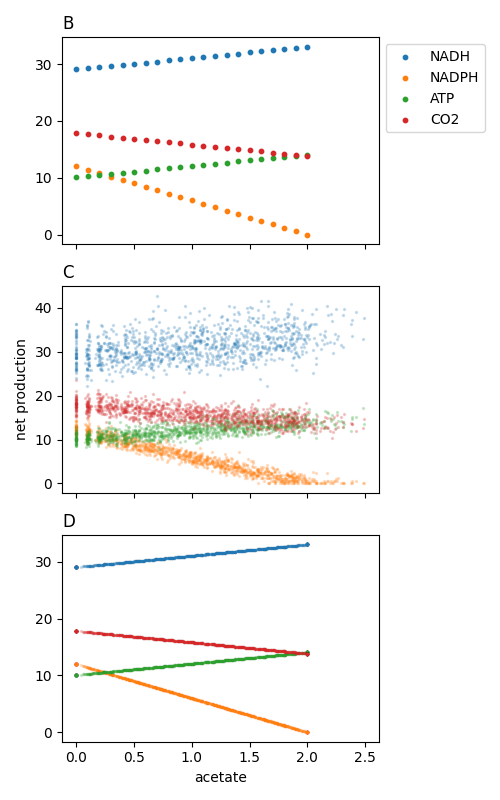

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(5, 8), sharex=True)
scatter_ov(ov_scan, ax[0], markersize=10).set_title('B', loc='left')
scatter_ov(ov_v0s, ax[1], markersize=2, alpha=0.2).set_title('C', loc='left')
scatter_ov(ov_dense, ax[2], markersize=2, alpha=0.2).set_title('D', loc='left')
ax[1].set_ylabel('net production')
ax[2].set_xlabel('acetate')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.tight_layout()
plt.show()

## Reverse the Logic: Infer Biomass Fractions from External Profile + Growth Rate

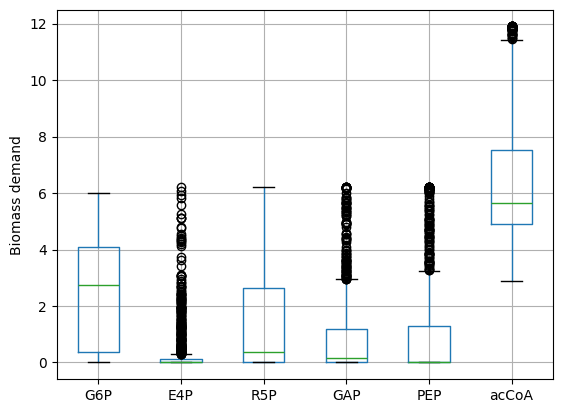

In [13]:
profile_mols = [KB(mol_id) for mol_id in ['Glc.D.ext', 'co2', 'pi', 'ac']]
profile = {k: v for k, v in limits.items()}
profile.update({mol: fba_soln_2.dmdt[pw.molecules.index_of(mol)] for mol in profile_mols})

objectives = {
    'steady-state': fba_gd.SteadyStateObjective(pw, intermediates),
    'biomass': BiomassObjective(pw, biomass_components, growth_rate),
    'profile': fba_gd.ProductionObjective(pw, profile),
}

# We need bounds for the biomass fractions, so set it up for irreversibility too
bounds = [(-np.inf, np.inf) if rxn.reversible else (0, np.inf) for rxn in pw.reactions] + [(0, np.inf)] * len(biomass_components)
lb, ub = np.array(bounds).T

parms = {name: objective.params() for name, objective in objectives.items()}
# Input vector x structured as <fluxv><biomass-fraction>
def fun(x):
    fluxv = x[:pw.shape[1]]
    dmdtv = pw.s_matrix @ fluxv
    parms['biomass'] = (x[pw.shape[1]:], growth_rate)
    residuals = [objective.residual(fluxv, dmdtv, parms[name]) for name, objective in objectives.items()]
    return jnp.concatenate(residuals)

_jit = jax.jit(fun)
_jac = jax.jit(jax.jacfwd(fun))

results = []
for i in range(1000):
    x0 = rando.random(pw.shape[1] + len(biomass_components))
    soln = scipy.optimize.least_squares(fun=_jit, x0=x0, jac=_jac, bounds=(lb, ub))
    results.append((x0, soln))

fractions = []
for result in results:
    soln = result[1]
    fractions.append(soln.x[pw.shape[1]:])
fractions_df = pd.DataFrame(fractions, columns=[mol.label for mol in biomass_components])

fig, ax = plt.subplots()
fractions_df.boxplot(ax=ax)
# ax.set_yscale('log')
ax.set_ylabel('Biomass demand')
display(fig)
plt.close(fig)

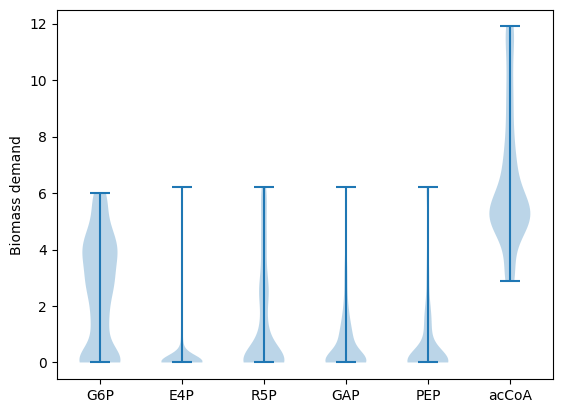

In [14]:
fig, ax = plt.subplots()
cols = ['G6P', 'E4P', 'R5P', 'GAP', 'PEP', 'acCoA']
ax.violinplot(fractions_df[cols])
ax.set_xticks(np.arange(len(cols)) + 1, labels=cols)
ax.set_ylabel('Biomass demand')
display(fig)
plt.close(fig)

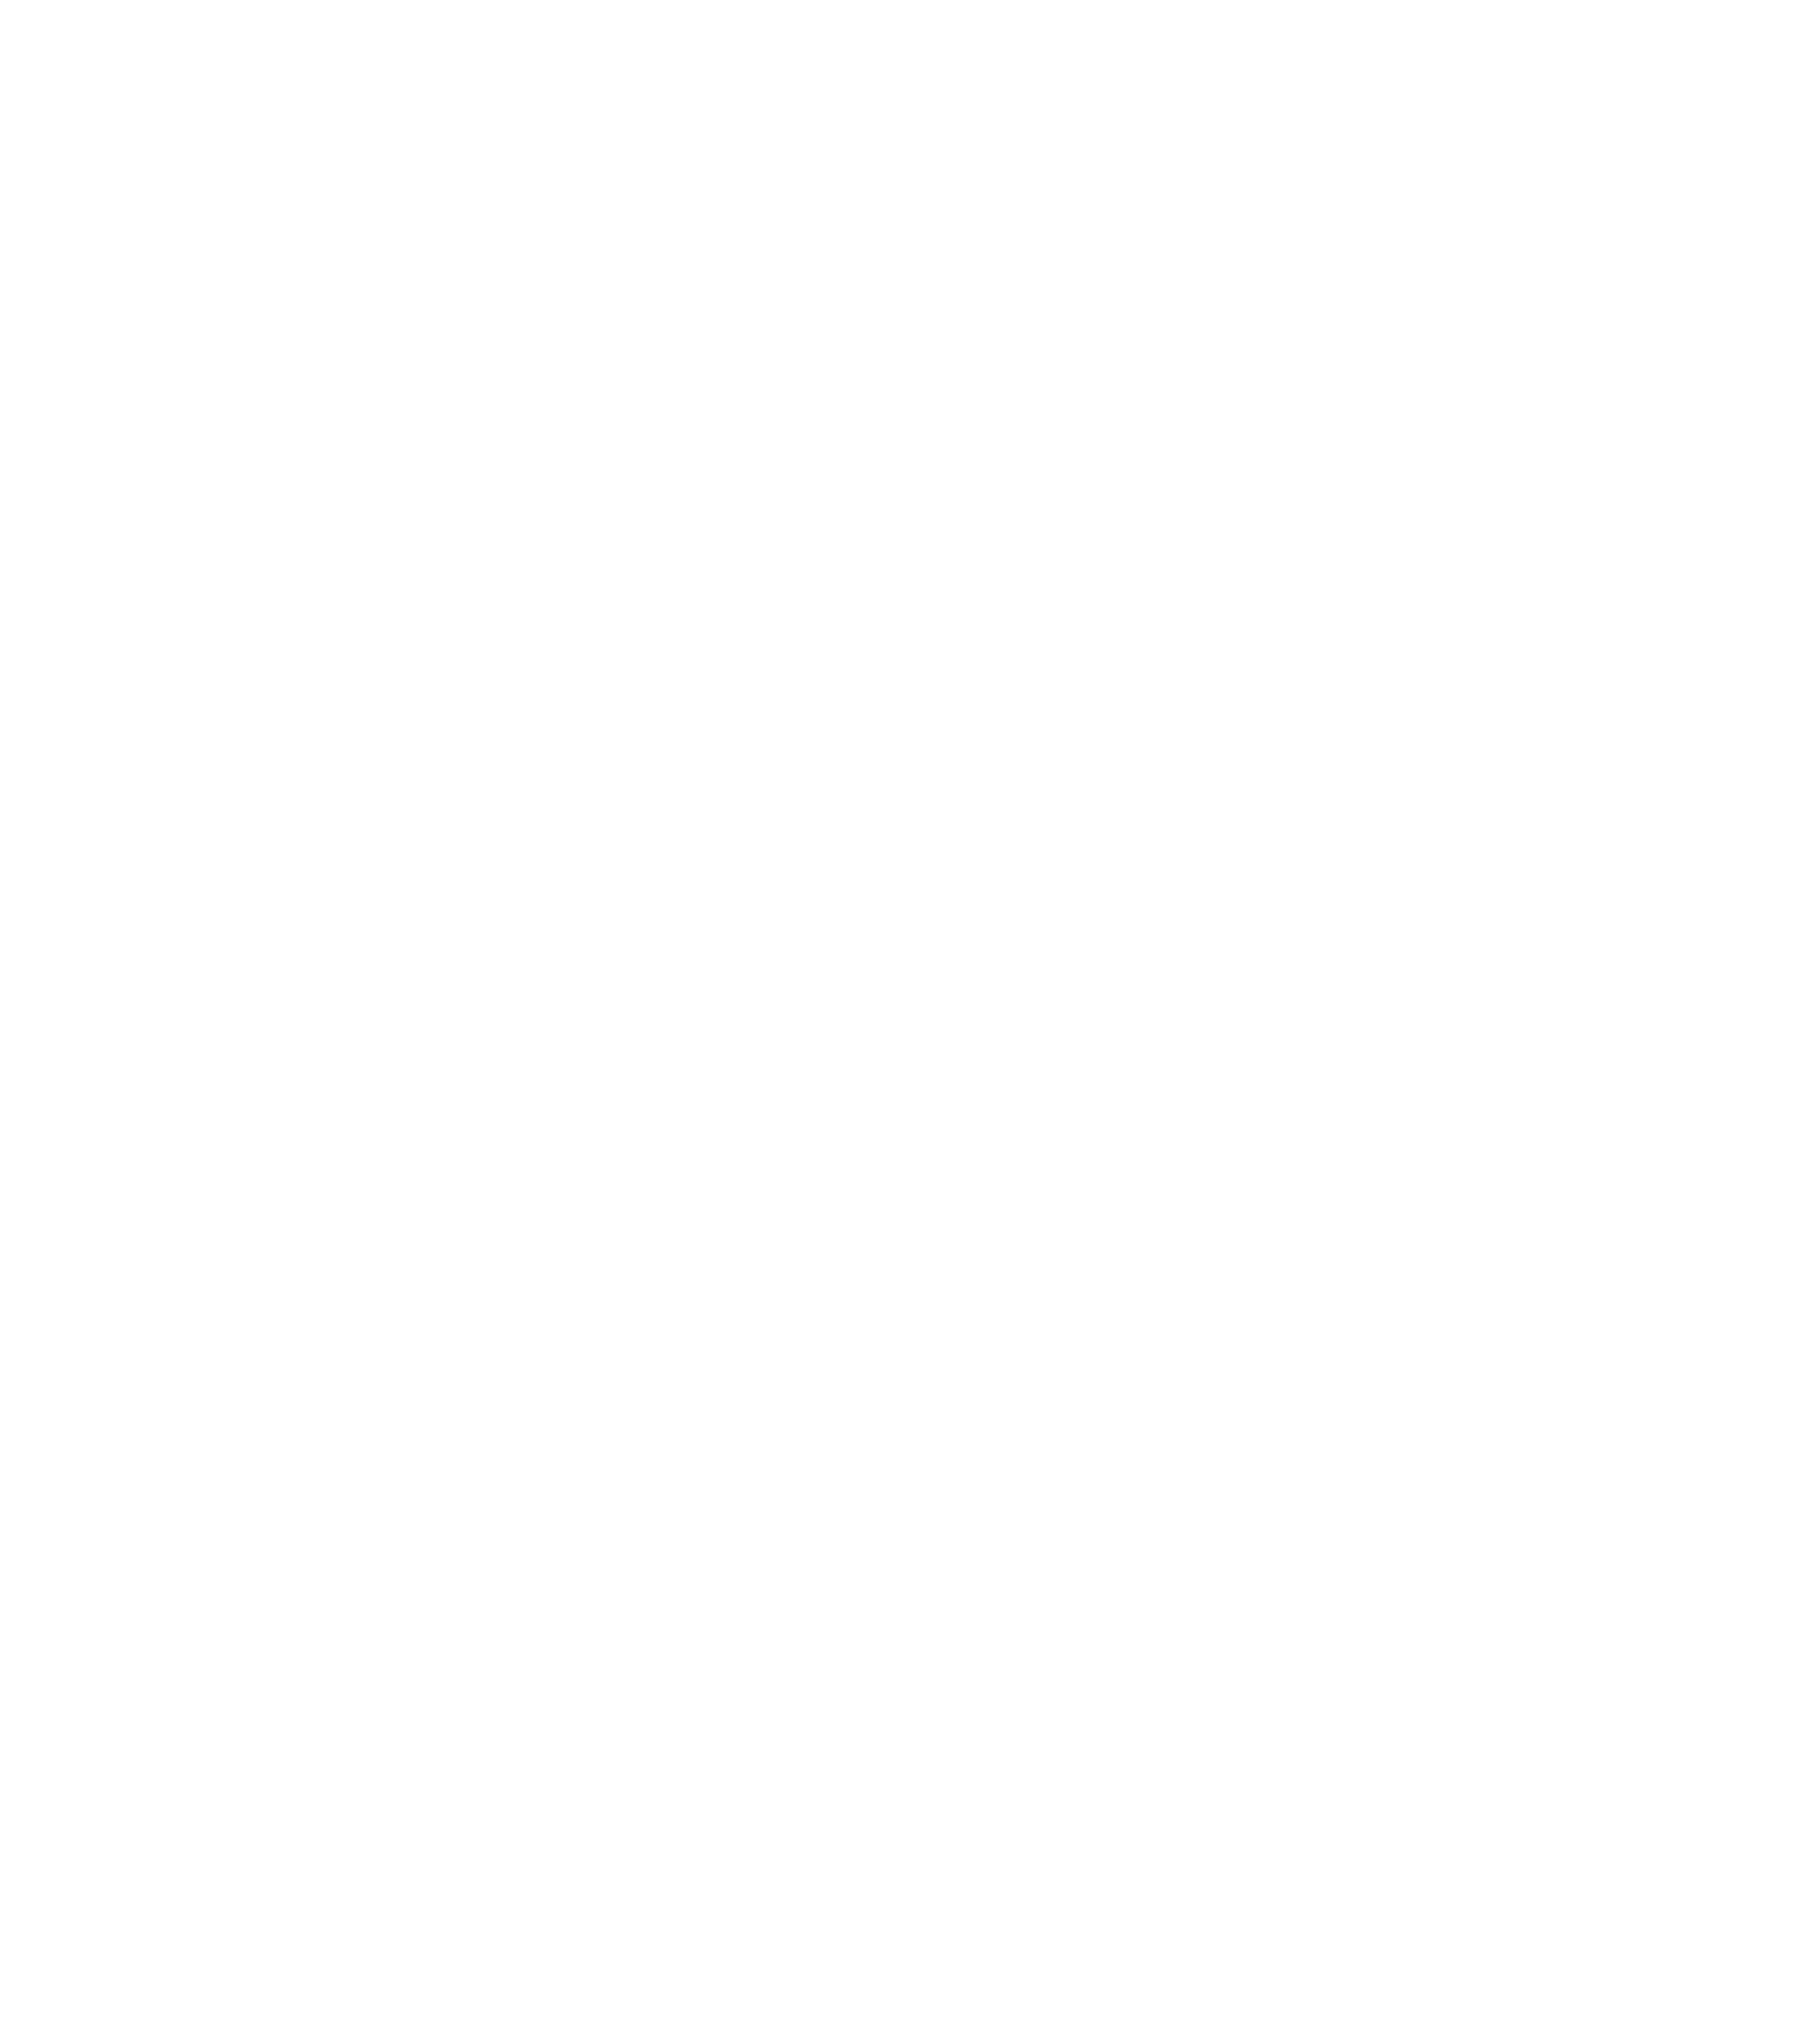

In [15]:
fluxes = []
for result in results:
    soln = result[1]
    fluxes.append(soln.x[:pw.shape[1]])
fluxes_df = pd.DataFrame(fluxes, columns=[r.label for r in pw.reactions])

variability = {r: np.std(fluxes_df[r.label]) / abs(np.mean(fluxes_df[r.label])) for r in pw.reactions}
diag = escher_map.EscherMap(pw.diagram, width='15cm', reaction_scale=escher_map.Scale({-8: ('#000000', 8), 0: ('#ffcccc', 40)}))
SVG(diag.draw(
    reaction_data={r.id: np.log(v) for r, v in variability.items()},
    reaction_direction={r.id: np.mean(fluxes_df[r.label]) for r in pw.reactions}
))

## Tables and Supplemental Data

In [16]:
table_1 = pd.DataFrame([
    {'reaction': r.label, 'ΔG°': _dgr0, 'ΔG': _dgr, 'flux': f'{_flux: .2f}', 'violation': 'X' if (_dgr * _flux) > 0 else ''}
    for r, _dgr0, _dgr, _flux
    in zip(pw.reactions, dgr0, dgr_ref, lp_soln.x[1:])
])
table_1

,reaction,ΔG°,ΔG,flux,violation
0,GAPDH,-0.127802,-6.526546,17.21,
1,PGK,18.165220,-0.880978,-17.21,X
2,GPM,-3.075978,4.191947,-17.21,
3,ENO,-4.266754,-2.474664,17.21,
4,PDH,-32.391010,-53.315348,11.83,
5,PYK,25.492557,10.430665,-1.83,
6,TPI,-6.558147,-0.310526,-8.98,X
7,FBA,29.147776,3.847842,8.98,X
8,PFK,-19.219892,-21.943203,8.98,
9,PGI,0.065214,-2.873139,9.77,


In [17]:
noconc = ('H+', 'H2O', 'e-')
table_s1 = pd.DataFrame(sorted([{
    'metabolite': m.label,
    'name': m.name,
    'CHEBI': ', '.join(xref.id for xref in m.xrefs if xref.db == DS.CHEBI),
    'boundary': 'X' if m in boundaries else '',
    'concentration (mM)': f'{concs[m] * 1000: .2e}' if m.label not in noconc else '-',
} for m in pw.molecules], key=lambda row: row['metabolite']))
table_s1

,metabolite,name,CHEBI,boundary,concentration (mM)
0,2PG,2-phospho-D-glycerate,58289,,9.18e-02
1,3PG,3-phospho-D-glycerate,58272,,1.54e+00
2,6PG,6-phosphogluconate,58759,,3.77e+00
3,6PGDL,6-phosphogluconolactone,57955,,1.00e+00
4,ADP,adenosine diphosphate,456216,,5.55e-01
5,ATP,adenosine triphosphate,30616,,9.63e+00
6,CO2,carbon dioxide,16526,X,7.52e-02
7,CoA,coenzyme A,57287,X,1.37e+00
8,DHAP,glycerone phosphate,57642,,3.06e+00
9,DPG,"1,3-bisphospho-D-glycerate",57604,,1.65e-02


In [18]:
table_s2 = pd.DataFrame([{
    'reaction': r.label,
    'name': r.name,
    'equation': r.equation,
    'EC': ', '.join(xref.id for xref in (r.xrefs or []) if xref.db == DS.EC),
    'RHEA': ', '.join(xref.id for xref in (r.xrefs or []) if xref.db == DS.RHEA),
} for r in pw.reactions])
table_s2

,reaction,name,equation,EC,RHEA
0,GAPDH,Glyceraldehyde-3-phosphate Dehydrogenase,GAP + NAD+ + Pi <=> DPG + H+ + NADH,1.2.1.12,10300
1,PGK,Phosphoglycerate Kinase,3PG + ATP <=> DPG + ADP,2.7.2.3,14801
2,GPM,Phosphoglycerate Mutase,2PG <=> 3PG,5.4.2.12,15901
3,ENO,Enolase,2PG <=> H2O + PEP,4.2.1.11,10164
4,PDH,Pyruvate Dehydrogenase,CoA + NAD+ + pyr => acCoA + CO2 + NADH,1.2.1.104,28042
5,PYK,Pyruvate Kinase,ATP + pyr <=> ADP + H+ + PEP,2.7.1.40,18157
6,TPI,Triose-phosphate Isomerase,GAP <=> DHAP,5.3.1.1,18585
7,FBA,Fructose-bisphosphate Aldolase,FDP <=> GAP + DHAP,4.1.2.13,14729
8,PFK,6-phosphofructokinase,ATP + F6P => ADP + FDP + H+,2.7.1.11,16109
9,PGI,Glucose-6-phosphate Isomerase,G6P <=> F6P,5.3.1.9,11816
